In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from scipy.signal import convolve2d
from imageio import imread

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

C:\Users\roger\AppData\Local\Temp\ipykernel_16508\1577475357.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


### Create Gaussian blurs with different widths

In [3]:
nPerClass=1000
imgsize=91
x=np.linspace(-4,4,imgsize)
X,Y=np.meshgrid(x,x)

widths=[1.8,2.4]

images=torch.zeros(2*nPerClass,1,imgsize,imgsize)
labels=torch.zeros(2*nPerClass)

for i in range(2*nPerClass):
    ro=2*np.random.randn(2)
    G=np.exp( -((X-ro[0])**2 + (Y-ro[1])**2)/(2*widths[i%2]**2))

    G=G+ np.random.randn(imgsize,imgsize)/5

    images[i,:,:,:]=torch.Tensor(G).view(1,imgsize,imgsize)
    labels[i]= i%2

labels=labels[:,None]

### Visualize some images

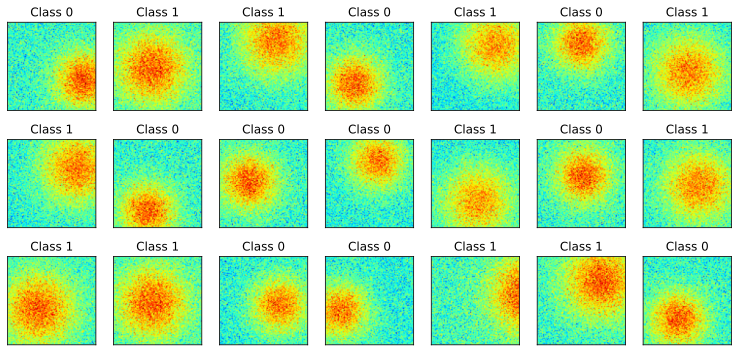

In [5]:
fig,axs=plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
    whichpic=np.random.randint(2*nPerClass)
    G=np.squeeze(images[whichpic,:,:])
    ax.imshow(G,vmin=-1,cmap='jet')
    ax.set_title('Class %s'%int(labels[whichpic].item()))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Create train/test groups using DataLoader

In [6]:
train_data, test_data, train_labels, test_labels = train_test_split(
        images, labels, test_size=.20)


train_data=TensorDataset(train_data,train_labels)
test_data=TensorDataset(test_data,test_labels)

batchsize=32
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

## Create tha DL Model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def makeTheNet():
    class gausnet(nn.Module):
        def __init__(self):
            super().__init__()

            self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
            self.conv2 = nn.Conv2d(6, 4, 3, padding=1)

            self.fc1 = nn.Linear(22 * 22 * 4, 50)
            self.fc2 = nn.Linear(50, 1)

        def forward(self, x):
            conv1act = F.relu(self.conv1(x))  # ✅ self.conv1
            x = F.avg_pool2d(conv1act, (2, 2))

            conv2act = F.relu(self.conv2(x))  # ✅ self.conv2
            x = F.avg_pool2d(conv2act, (2, 2))

            x = x.reshape(x.shape[0], -1)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)

            return x, conv1act, conv2act

    net = gausnet()
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

    return net, lossfun, optimizer


In [10]:
net, lossfun, optimizer = makeTheNet()

# Get a batch of data
X, y = next(iter(train_loader))

# Make sure target is float and shape is [batch_size, 1]
y = y.float().view(-1, 1)

# Forward pass
yHat, featmap1, featmap2 = net(X)

# Compute loss
loss = lossfun(yHat, y)

# Print results
print('Predicted category:')
print(yHat.shape)

print('\nFeature map after conv1')
print(featmap1.shape)

print('\nFeature map after conv2')
print(featmap2.shape)

print('\nLoss:', loss.item())


Predicted category:
torch.Size([32, 1])

Feature map after conv1
torch.Size([32, 6, 91, 91])

Feature map after conv2
torch.Size([32, 4, 45, 45])

Loss: 0.6953145861625671


In [11]:
summary(net,(1,imgsize,imgsize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
            Conv2d-2            [-1, 4, 45, 45]             220
            Linear-3                   [-1, 50]          96,850
            Linear-4                    [-1, 1]              51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84
----------------------------------------------------------------
